In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Setup Device (MPS for Mac, CUDA for Nvidia, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
class ShapesDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # We need to map sides (3,4,5,6) to model indices (0,1,2,3)
        self.class_map = {3: 0, 4: 1, 5: 2, 6: 3}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image name from the 'filename' column
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        
        # Get label from the 'sides' column
        sides = self.data_frame.iloc[idx]['sides']
        label = self.class_map[sides] # Convert 3->0, 4->1, etc.

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# HYPERPARAMETERS
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20

# Define Paths (CHANGE THESE TO YOUR ACTUAL PATHS)
CSV_PATH = '/Users/blasmorenolaguna/Documents/TODO/University/Applied ML/CNN/archive/targets.csv'      # Path to your uploaded csv
IMG_FOLDER = '/Users/blasmorenolaguna/Documents/TODO/University/Applied ML/CNN/archive/images/content/images' # Path to the folder containing the images

# 1. Define Transforms
# We resize to 64x64. You can increase this to 128x128 if shapes are complex, 
# but 64 is usually fine for geometric shapes.
data_transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 2. Instantiate Dataset
full_dataset = ShapesDataset(csv_file=CSV_PATH, img_dir=IMG_FOLDER, transform=data_transform)

# 3. Split into Train and Test (e.g., 80% Train, 20% Test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaded: {len(train_dataset)} training images, {len(test_dataset)} test images.")

Data loaded: 8000 training images, 2000 test images.


In [5]:
class ShapeClassifier(nn.Module):
    def __init__(self):
        super(ShapeClassifier, self).__init__()
        
        # Convolutional layers to extract features
        self.features = nn.Sequential(
            # Conv Layer 1: Input 3 channels (RGB), Output 16 channels
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Image becomes 32x32
            
            # Conv Layer 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Image becomes 16x16
            
            # Conv Layer 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Image becomes 8x8
        )
        
        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), # 64 channels * 8x8 image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4) # Output is 4 (Triangle, Square, Pentagon, Hexagon)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = ShapeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

print("Training Finished!")

Epoch [1/20], Loss: 0.3147
Epoch [2/20], Loss: 0.2890
Epoch [3/20], Loss: 0.2739
Epoch [4/20], Loss: 0.2548
Epoch [5/20], Loss: 0.2273
Epoch [6/20], Loss: 0.2113
Epoch [7/20], Loss: 0.2019
Epoch [8/20], Loss: 0.1794
Epoch [9/20], Loss: 0.1850
Epoch [10/20], Loss: 0.1607
Epoch [11/20], Loss: 0.1564
Epoch [12/20], Loss: 0.1573
Epoch [13/20], Loss: 0.1334
Epoch [14/20], Loss: 0.1215
Epoch [15/20], Loss: 0.1107
Epoch [16/20], Loss: 0.1069
Epoch [17/20], Loss: 0.0950
Epoch [18/20], Loss: 0.1014
Epoch [19/20], Loss: 0.0889
Epoch [20/20], Loss: 0.0879
Training Finished!


In [10]:
def print_metrics(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("-" * 20)
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.3f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.3f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.3f}")

model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Map indices back to names for clarity if needed, but metrics function takes numbers
print_metrics(all_labels, all_preds)

Confusion Matrix:
[[479   5   0   0]
 [  1 478   5   0]
 [  0   3 495  15]
 [  0   0  29 490]]
--------------------
Precision: 0.971
Recall:    0.971
F1 Score:  0.971


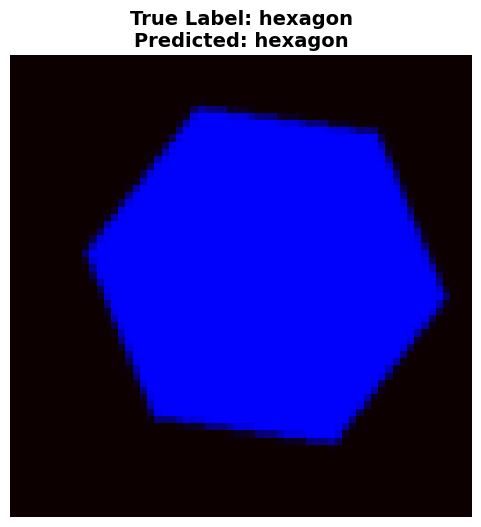


Image Classification Result (Random Test Image #1331):
True Class: hexagon (class 3)
Predicted Class: hexagon (class 3)
✓ Correct prediction!


In [ ]:
import matplotlib.pyplot as plt
import random

# Class mapping
class_names = {0: 'triangle', 1: 'square', 2: 'pentagon', 3: 'hexagon'}

# Get a random sample image from test dataset
model.eval()
with torch.no_grad():
    # Randomly pick an index from the test dataset
    random_idx = random.randint(0, len(test_dataset) - 1)
    
    # Get the image and label at that random index
    sample_image, true_label = test_dataset[random_idx]
    
    # Add batch dimension and move to device
    sample_image = sample_image.unsqueeze(0).to(device)  # Shape: (1, C, H, W)
    true_label = true_label
    
    # Get prediction
    outputs = model(sample_image)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted[0].item()
    
    # Get the image for display (denormalize and convert to numpy)
    img_display = sample_image[0].cpu()  # Remove batch dimension
    
    # Denormalize: reverse the normalization (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    img_display = img_display * 0.5 + 0.5  # Reverse: (x * std) + mean = (x * 0.5) + 0.5
    img_display = torch.clamp(img_display, 0, 1)  # Ensure values are in [0, 1]
    
    # Convert to numpy and change from (C, H, W) to (H, W, C) for matplotlib
    img_np = img_display.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f'True Label: {class_names[true_label]}\nPredicted: {class_names[predicted_class]}', 
              fontsize=14, fontweight='bold')
    plt.show()
    
    # Print classification result
    print(f"\nImage Classification Result (Random Test Image #{random_idx}):")
    print(f"True Class: {class_names[true_label]} (class {true_label})")
    print(f"Predicted Class: {class_names[predicted_class]} (class {predicted_class})")
    if true_label == predicted_class:
        print("✓ Correct prediction!")
    else:
        print("✗ Incorrect prediction")
